# UAS MACHINE LEARNING 3

Arieldhipta Tarliman - 2702234636

# Make a restaurant recommender system.


# Dataset

Dataset 3B (restaurant recommendation)
- url: the restaurant’s Zomato URL
- name: the restaurant’s name
- online_order: whether the restaurant accepts online orders or not (yes/no)
- book_table: whether the customers can book tables at the restaurant (yes/no)
- rate: the overall rating given to the restaurant on Zomato (0-5)
- votes: the number of people who have rated the restaurant
- location: location of the restaurant
- rest_type: the type of the restaurant (such as quick bites, casual dining, etc)
- cuisines: types of cuisines served at the restaurant
- approx_cost(for two people): approximate costs for 2 people’s meal (Rupee)
- listed_in(type): category of the restaurant (delivery, dine-out, etc)
- sell_beverages: whether the restaurant sells beverages
- sell_chinese_food: whether the restaurant sells Chinese food
- sell_thai_food: whether the restaurant sells Thai food
- sell_indian_food: whether the restaurant sells Indian food
- sell_mediterranean_food: whether the restaurant sells Mediterranean food
- sell_fast_food: whether the restaurant sells fast food
- sell_desserts: whether the restaurant sells desserts

# Import Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import ftfy  
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from sklearn.preprocessing import RobustScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import logging
logging.basicConfig(filename='warnings3.log', level=logging.WARNING)
logging.captureWarnings(True) 
import random
SEED = 42
random.seed(SEED)
np.random.seed(SEED)


# Read Dataset

In [2]:
df = pd.read_csv('3B.tsv', sep='\t',encoding='utf-8')

## Simple EDA

In [3]:
df.head()

,url,name,online_order,book_table,rate,votes,location,rest_type,cuisines,approx_cost(for two people),listed_in(type),sell_beverages,sell_chinese_food,sell_thai_food,sell_indian_food,sell_mediterranean_food,sell_fast_food,sell_desserts
0,https://www.zomato.com/bangalore/faasos-1-vasa...,Faasos,Yes,No,3.8,101,Vasanth Nagar,Delivery,"North Indian, Biryani, Fast Food",500,Delivery,no,no,no,yes,no,yes,no
1,https://www.zomato.com/bangalore/khanapur-expr...,Khanapur Express,No,No,NaN,0,JP Nagar,Quick Bites,"North Indian, Rajasthani",500,Delivery,no,no,no,yes,no,no,no
2,https://www.zomato.com/bangalore/russh-gastrop...,Russh Gastropub,No,No,4.2,1279,Church Street,Pub,"Continental, Italian, Burger","1,100",Drinks & nightlife,no,no,no,no,no,yes,no
3,https://www.zomato.com/bangalore/bangalir-rann...,Bangalir Rannaghar,No,No,2.9,58,Bannerghatta Road,Quick Bites,"Bengali, North Indian, Chinese",250,Dine-out,no,yes,no,yes,no,no,no
4,https://www.zomato.com/bangalore/natural-mumba...,Natural Mumbai Kulfi,Yes,No,3.5,8,BTM,Dessert Parlor,Ice Cream,130,Delivery,no,no,no,no,no,no,yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   url                          15000 non-null  object
 1   name                         15000 non-null  object
 2   online_order                 15000 non-null  object
 3   book_table                   15000 non-null  object
 4   rate                         12736 non-null  object
 5   votes                        15000 non-null  int64 
 6   location                     14992 non-null  object
 7   rest_type                    14931 non-null  object
 8   cuisines                     14988 non-null  object
 9   approx_cost(for two people)  14908 non-null  object
 10  listed_in(type)              15000 non-null  object
 11  sell_beverages               14988 non-null  object
 12  sell_chinese_food            14988 non-null  object
 13  sell_thai_food               14

In [5]:
df.describe()

,votes
count,15000.000000
mean,285.355000
std,812.512684
min,-1.000000
25%,7.000000
50%,39.000000
75%,197.000000
max,16832.000000


# Handling Duplicated Value

In [6]:
df.duplicated().sum()

0

# Handling Column

## Changing the column names

In [7]:
df = df.rename(columns={'approx_cost(for two people)':'cost','listed_in(type)':'type', 'listed_in(city)':'city'})

## Drop url column

In [8]:
df.drop('url', axis=1, inplace=True)

## Change rate datatype & remove anomaly


In [9]:
print(df['rate'].unique())
df = df[~df['rate'].isin(['NEW', 'X', '-'])]
df = df.reset_index(drop=True)
df['rate'] = df['rate'].astype(float)

['3.8' nan '4.2' '2.9' '3.5' '3.5 ' '4.4' '4.3' '4.2 ' '3.6' '2.6' '2.7 '
 '3.1' '3.2 ' '3.6 ' '4.1 ' '3.2' '3.8 ' '4.5' '3.3 ' '4.4 ' '4.6' '4.1'
 '4.0 ' '4.5 ' '3.4' '3.1 ' 'NEW' '3.7' '3.9 ' '3.9' '4.0' '2.4' '3.0'
 '3.7 ' '3.4 ' '2.6 ' '2.8 ' '3.3' '4.3 ' '3.0 ' '4.9 ' '2.8' '2.5 '
 '4.6 ' '2.9 ' '2.7' '-' 'X' '4.7' '2.2 ' '4.8 ' '4.8' '2.1' '4.7 ' '2.3'
 '2.5' '2.3 ' '2.4 ' '2.1 ' '2.0 ' '4.9' '2.2' '1.8 ']


## Change cost datatype & change anomaly format


In [10]:
print(df['cost'].unique())
df['cost'] = pd.to_numeric(df['cost'].str.replace(',', ''), errors='coerce')


['500' '1,100' '250' '130' '200' '1,000' '350' nan '750' '400' '550' '450'
 '300' '800' '1,200' '650' '1,400' '2,000' '600' '900' '1,500' '700'
 '1,600' '950' '1,800' '150' '1,900' '2,500' '1,300' '2,400' '100' '2,200'
 '3,000' '1,700' '850' '4,000' '2,100' '180' '360' '120' '3,500' '3,700'
 '80' '1,650' '2,800' '230' '199' '2,300' '1,250' '40' '4,500' '330'
 '1,350' '5,000' '3,400' '1,050' '50' '240' '2,600' '1,450']


# Handling Missing Value

## Check Missing Value

In [11]:
print("Missing values:")
df.isna().sum()

Missing values:


name                          0
online_order                  0
book_table                    0
rate                       2264
votes                         0
location                      7
rest_type                    67
cuisines                     11
cost                         89
type                          0
sell_beverages               11
sell_chinese_food            11
sell_thai_food               11
sell_indian_food             11
sell_mediterranean_food      11
sell_fast_food               11
sell_desserts                11
dtype: int64

In [12]:
print(f'Total percentage of missing value : {(df.isna().sum().sum()) / len(df) * 100}%')

Total percentage of missing value : 17.54080066954945%


On the rate column there is a possible where it dont have any rates because it haven't been voted yet.

# Futrher Elaboration

In [ ]:
missing_rate = df[df['rate'].isna()]
zero_votes = missing_rate[missing_rate['votes'] == 0]
have_votes = missing_rate[missing_rate['votes'] != 0]


print(f"Customers with missing rate and no votes: {len(zero_votes)}")
print(f"Percentage of missing rate due to no votes: {len(zero_votes) / len(missing_rate) * 100:.2f}%")

print(f"\nCustomers with missing rate and have votes: {len(have_votes)}")
print(f"Percentage of missing rate due to no votes: {len(have_votes) / len(missing_rate) * 100:.2f}%")

Customers with missing rate and no votes: 2240
Percentage of missing rate due to no votes: 98.94%

Customers with missing rate and have votes: 24
Percentage of missing rate due to no votes: 1.06%


From the result majority of all missing rate causes by having no votes itself (98.94%). It suggests these rows might lack valuable information and could be dropped. While the rest of 24 votes can be inputable with the rate from restaurants with similary attributes (rest_type, location).

In [ ]:
def impute_rate(row):
    if pd.isnull(row['rate']) and row['votes'] > 0:
        # Calculate the mean rate for similar restaurants
        similar = df[(df['location'] == row['location']) & (df['rest_type'] == row['rest_type'])]
        return similar['rate'].mean()
    return row['rate']

df['rate'] = df.apply(impute_rate, axis=1)

df = df[~((df['votes'] == 0) & (df['rate'].isnull()))]

In [15]:
print(f'Dataframe Shape: {df.shape}')
print("Missing values:")
print(df.isna().sum())
print(f'Total percentage of missing value : {(df.isna().sum().sum()) / len(df) * 100}%')

Dataframe Shape: (12098, 17)
Missing values:
name                        0
online_order                0
book_table                  0
rate                       14
votes                       0
location                    0
rest_type                  42
cuisines                    1
cost                       66
type                        0
sell_beverages              1
sell_chinese_food           1
sell_thai_food              1
sell_indian_food            1
sell_mediterranean_food     1
sell_fast_food              1
sell_desserts               1
dtype: int64
Total percentage of missing value : 1.0745577781451479%


Becuase of the rest missing values only affect 1 percent of 12098 row its better to drop all of it for more simplicity

In [16]:
df = df.dropna()
df = df.reset_index(drop=True)
print(f'Total percentage of missing value : {(df.isna().sum().sum()) / len(df) * 100}%')

Total percentage of missing value : 0.0%


# Handling Unique Value

In [ ]:
def show_unique_values(df, max_display=10):
    for column in df.columns:
        unique_values = sorted(df[column].unique())
        
        unique_count = len(unique_values)
        print(f"Column '{column}' has {unique_count} unique values.")
        
        if unique_count == len(df):
            print('Length of unique value is equal to the total row of the data.')
        elif unique_count > max_display:
            display_values = unique_values[:5] + ["..."] + unique_values[-5:]
            print(f"Sample unique values: {display_values}")
        else:
            print(f"Unique values: {unique_values}")
        print("-" * 50)

show_unique_values(df)

Column 'name' has 4738 unique values.
Sample unique values: ['#FeelTheROLL', '#L-81 Cafe', '1000 B.C', '100Ã\x83Â\x83Ã\x82Â\x83Ã\x83Â\x82Ã\x82Â\x82Ã\x83Â\x83Ã\x82Â\x82Ã\x83Â\x82Ã\x82Â°C', '11 to 11 Express Biriyanis', '...', 'i-Bar - The Park Bangalore', 'iFruit Live Ice Creams', 'iSpice Resto Cafe', 'nu.tree', 're:cess - Hilton Bangalore Embassy GolfLinks']
--------------------------------------------------
Column 'online_order' has 2 unique values.
Unique values: ['No', 'Yes']
--------------------------------------------------
Column 'book_table' has 2 unique values.
Unique values: ['No', 'Yes']
--------------------------------------------------
Column 'rate' has 37 unique values.
Sample unique values: [1.8, 2.0, 2.1, 2.2, 2.3, '...', 4.5, 4.6, 4.7, 4.8, 4.9]
--------------------------------------------------
Column 'votes' has 1590 unique values.
Sample unique values: [0, 2, 4, 5, 6, '...', 14710, 14717, 14723, 16345, 16832]
--------------------------------------------------
Column 

In [18]:
for i in df.columns:
    print(df[i].value_counts())
    print("")

name
Cafe Coffee Day             29
Onesta                      24
Faasos                      23
Burger King                 23
Petoo                       21
                            ..
Malgudi's Donne Biriyani     1
Rayalaseema Ruchulu          1
New Kohinoor Hotel           1
Wok N Roll                   1
Sri Vasavi Restaurant        1
Name: count, Length: 4738, dtype: int64

online_order
Yes    7869
No     4107
Name: count, dtype: int64

book_table
No     10137
Yes     1839
Name: count, dtype: int64

rate
3.700000    1100
3.900000    1087
3.800000    1053
3.600000     963
4.000000     949
4.100000     868
3.500000     801
3.400000     738
3.300000     671
4.200000     627
3.200000     520
3.100000     458
4.300000     453
4.400000     346
3.000000     278
2.900000     242
4.500000     201
2.800000     167
4.600000      95
2.700000      89
2.600000      80
4.700000      52
2.500000      31
4.800000      22
2.300000      19
4.900000      18
2.400000      17
2.100000      12
2.20

- Some of the value on the name are not well represented maybe was caused by diffrent text encoder / without correct encoding.
- Cuisines column has multi-value entries, while some individual cuisines are already represented in binary columns but not comprehensively.

### Format Column Name

In [19]:
pd.set_option('display.max_seq_items', None)
unique_names = df['name'].unique().tolist()
print(unique_names)

['Faasos', 'Russh Gastropub', 'Bangalir Rannaghar', 'Natural Mumbai Kulfi', 'Chai Resto', 'Mimansa @ Foxtrot', 'Ciclo Cafe', 'The Kebab House', 'Sri Krishna Kitchen', 'Pizza Hut', 'Havmor', 'Punjabi Tadka', 'Luqma Restaurant', 'Bhukkad', 'Calorie Express', 'Mustard Food Court', 'Puchkas', 'Mummy Dhaba', 'Simhapuri Mess', 'Squeez Juice Bar', 'Tandoor-De-Naal', 'Pot-O-Noodles', 'Infinitea Tea Room & Tea Store', 'The Chevron Brigade', 'Third Wave Coffee Roasters', "Smally's Resto Cafe", "AB's - Absolute Barbecues", 'Artinci Artisanal Ice Cream', 'Baskin Robbins', 'Meat And Eat', 'Tasting Room - Bengaluru Oota Company', 'Cafe Graffiters', 'Cafe Coffee Day', 'Toscano', 'Simu?s Kitchen', 'Onesta', 'The Coffee Bean & Tea Leaf', 'Blue Tokai Coffee Roasters', 'Tibbs Frankie', 'Biriyani Adda', 'Magic Box', 'New Biryani Mane', 'Yummy Biryani', "Baker's Home", 'Bite Me Cupcakes', 'InnerChef', 'Purani Dilli', 'Shang Palace - Shangri-La Hotel', 'Little Kitchen', 'Delicacy', 'Fullyfilled', 'Laughing 

In [ ]:
df['name'] = df['name'].apply(ftfy.fix_text)
ii = 0

def demoji(x):
    global ii
    try:
        y = x.encode('latin-1').decode('utf-8')
        ii += 1
    except:
        y = x
        ii = -ii
    return y

def moji(x):
    return x.encode('utf-8').decode('latin-1', 'backslashreplace')

df['name'] = df['name'].apply(demoji)

print(f"Counter value (ii): {ii}")
print("\nSample of fixed names:")
print(df['name'].head())

pd.reset_option('display.max_seq_items')

Counter value (ii): -407

Sample of fixed names:
0                  Faasos
1         Russh Gastropub
2      Bangalir Rannaghar
3    Natural Mumbai Kulfi
4              Chai Resto
Name: name, dtype: object


In [21]:
plot_df = df.copy()

# Summary

In [22]:
missing_values = df.isnull().mean()*100
data_type = df.dtypes
unique_values_count = df.nunique()

summary_1 = pd.DataFrame({
    'Null %': missing_values,
    'Datatype': data_type,
    'Unique value': unique_values_count
})

summary_1.sort_values(by = 'Null %', ascending= False)

,Null %,Datatype,Unique value
name,0.0,object,4720
type,0.0,object,7
sell_fast_food,0.0,object,2
sell_mediterranean_food,0.0,object,2
sell_indian_food,0.0,object,2
sell_thai_food,0.0,object,2
sell_chinese_food,0.0,object,2
sell_beverages,0.0,object,2
cost,0.0,float64,57
online_order,0.0,object,2


# Plot

In [ ]:
categorical_columns = []
numerical_columns = []

for i in df.columns:
    if i == "Obesity level":
        continue

    if 'int' in str(df[i].dtype) or 'float' in str(df[i].dtype):
        numerical_columns.append(i)
    else:
        categorical_columns.append(i)

print(f'Categorical: {categorical_columns}\n')
print(f'Numeric: {numerical_columns}')

Categorical: ['name', 'online_order', 'book_table', 'location', 'rest_type', 'cuisines', 'type', 'sell_beverages', 'sell_chinese_food', 'sell_thai_food', 'sell_indian_food', 'sell_mediterranean_food', 'sell_fast_food', 'sell_desserts']

Numeric: ['rate', 'votes', 'cost']


In [24]:
df[numerical_columns].describe()

,rate,votes,cost
count,11976.000000,11976.000000,11976.000000
mean,3.700500,355.684786,603.051854
std,0.445019,894.787018,465.846298
min,1.800000,0.000000,40.000000
25%,3.400000,21.000000,300.000000
50%,3.700000,73.000000,500.000000
75%,4.000000,281.000000,700.000000
max,4.900000,16832.000000,5000.000000


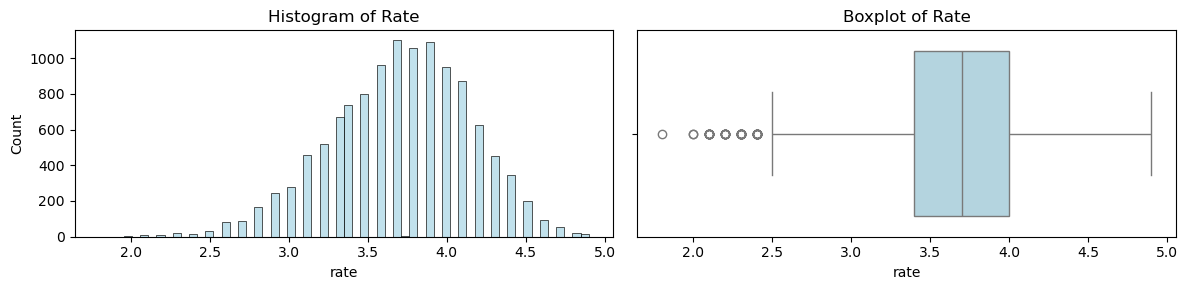

rate - Skewness: -0.3251208345485569
rate - Kurtosis: 0.01855123931825098


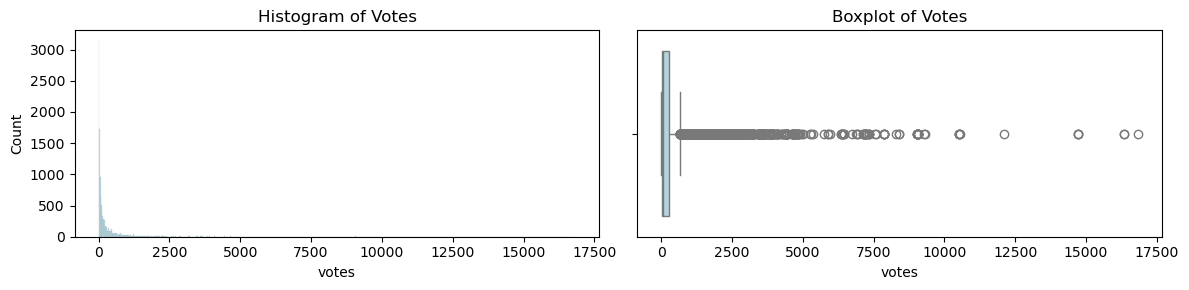

votes - Skewness: 6.959745005110461
votes - Kurtosis: 74.84311759071637


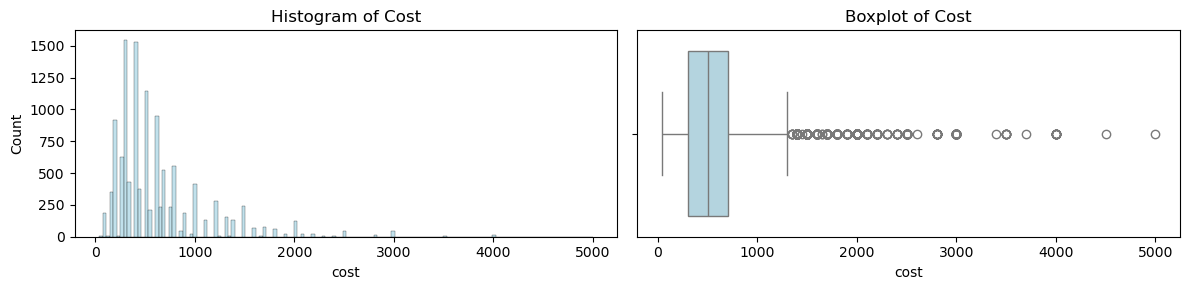

cost - Skewness: 2.429769344121362
cost - Kurtosis: 8.784956002791798


In [25]:
for i, var in enumerate(numerical_columns, 1):
    plt.figure(figsize=(12, 3))  
    plt.subplot(1, 2, 1)
    sns.histplot(df[var], color= 'lightblue')  
    plt.title(f"Histogram of {var.capitalize()}")
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[var], color= 'lightblue')
    plt.title(f"Boxplot of {var.capitalize()}")
    plt.tight_layout()
    plt.show()
    print(f'{var} - Skewness: {df[var].skew()}')
    print(f'{var} - Kurtosis: {df[var].kurt()}')

In [26]:
df['votes'].unique().sort()

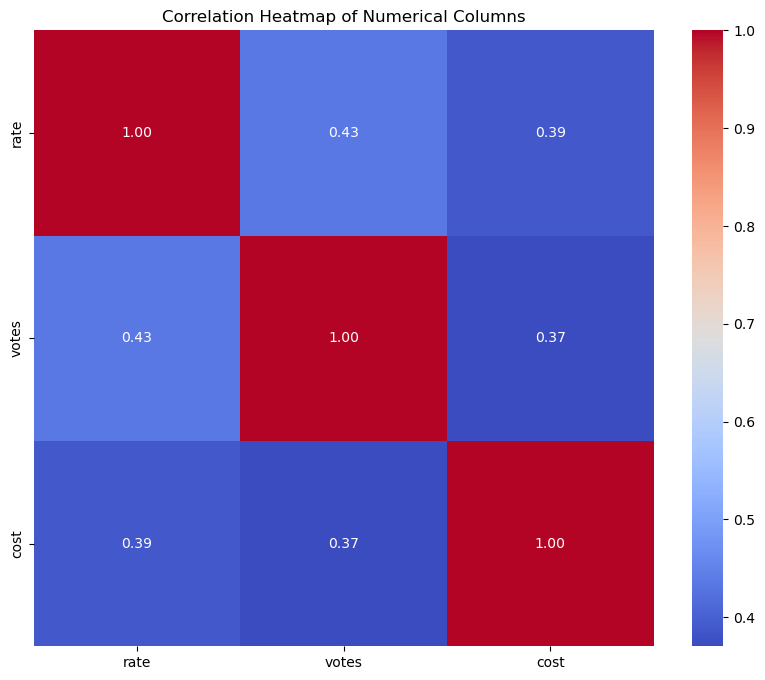

In [ ]:
corr_matrix = df[numerical_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Numerical Columns")
plt.show()

## Insight

- Rate columns overall has a great distribution with it skewed more to the right, with the average rate of 3.7
- votes has high variety the data was very skwed to the left with so many otliers with high values
- Cost was also vary, most of it maintain low cost of monthly
- There are no significcant correlation between the numerical columns

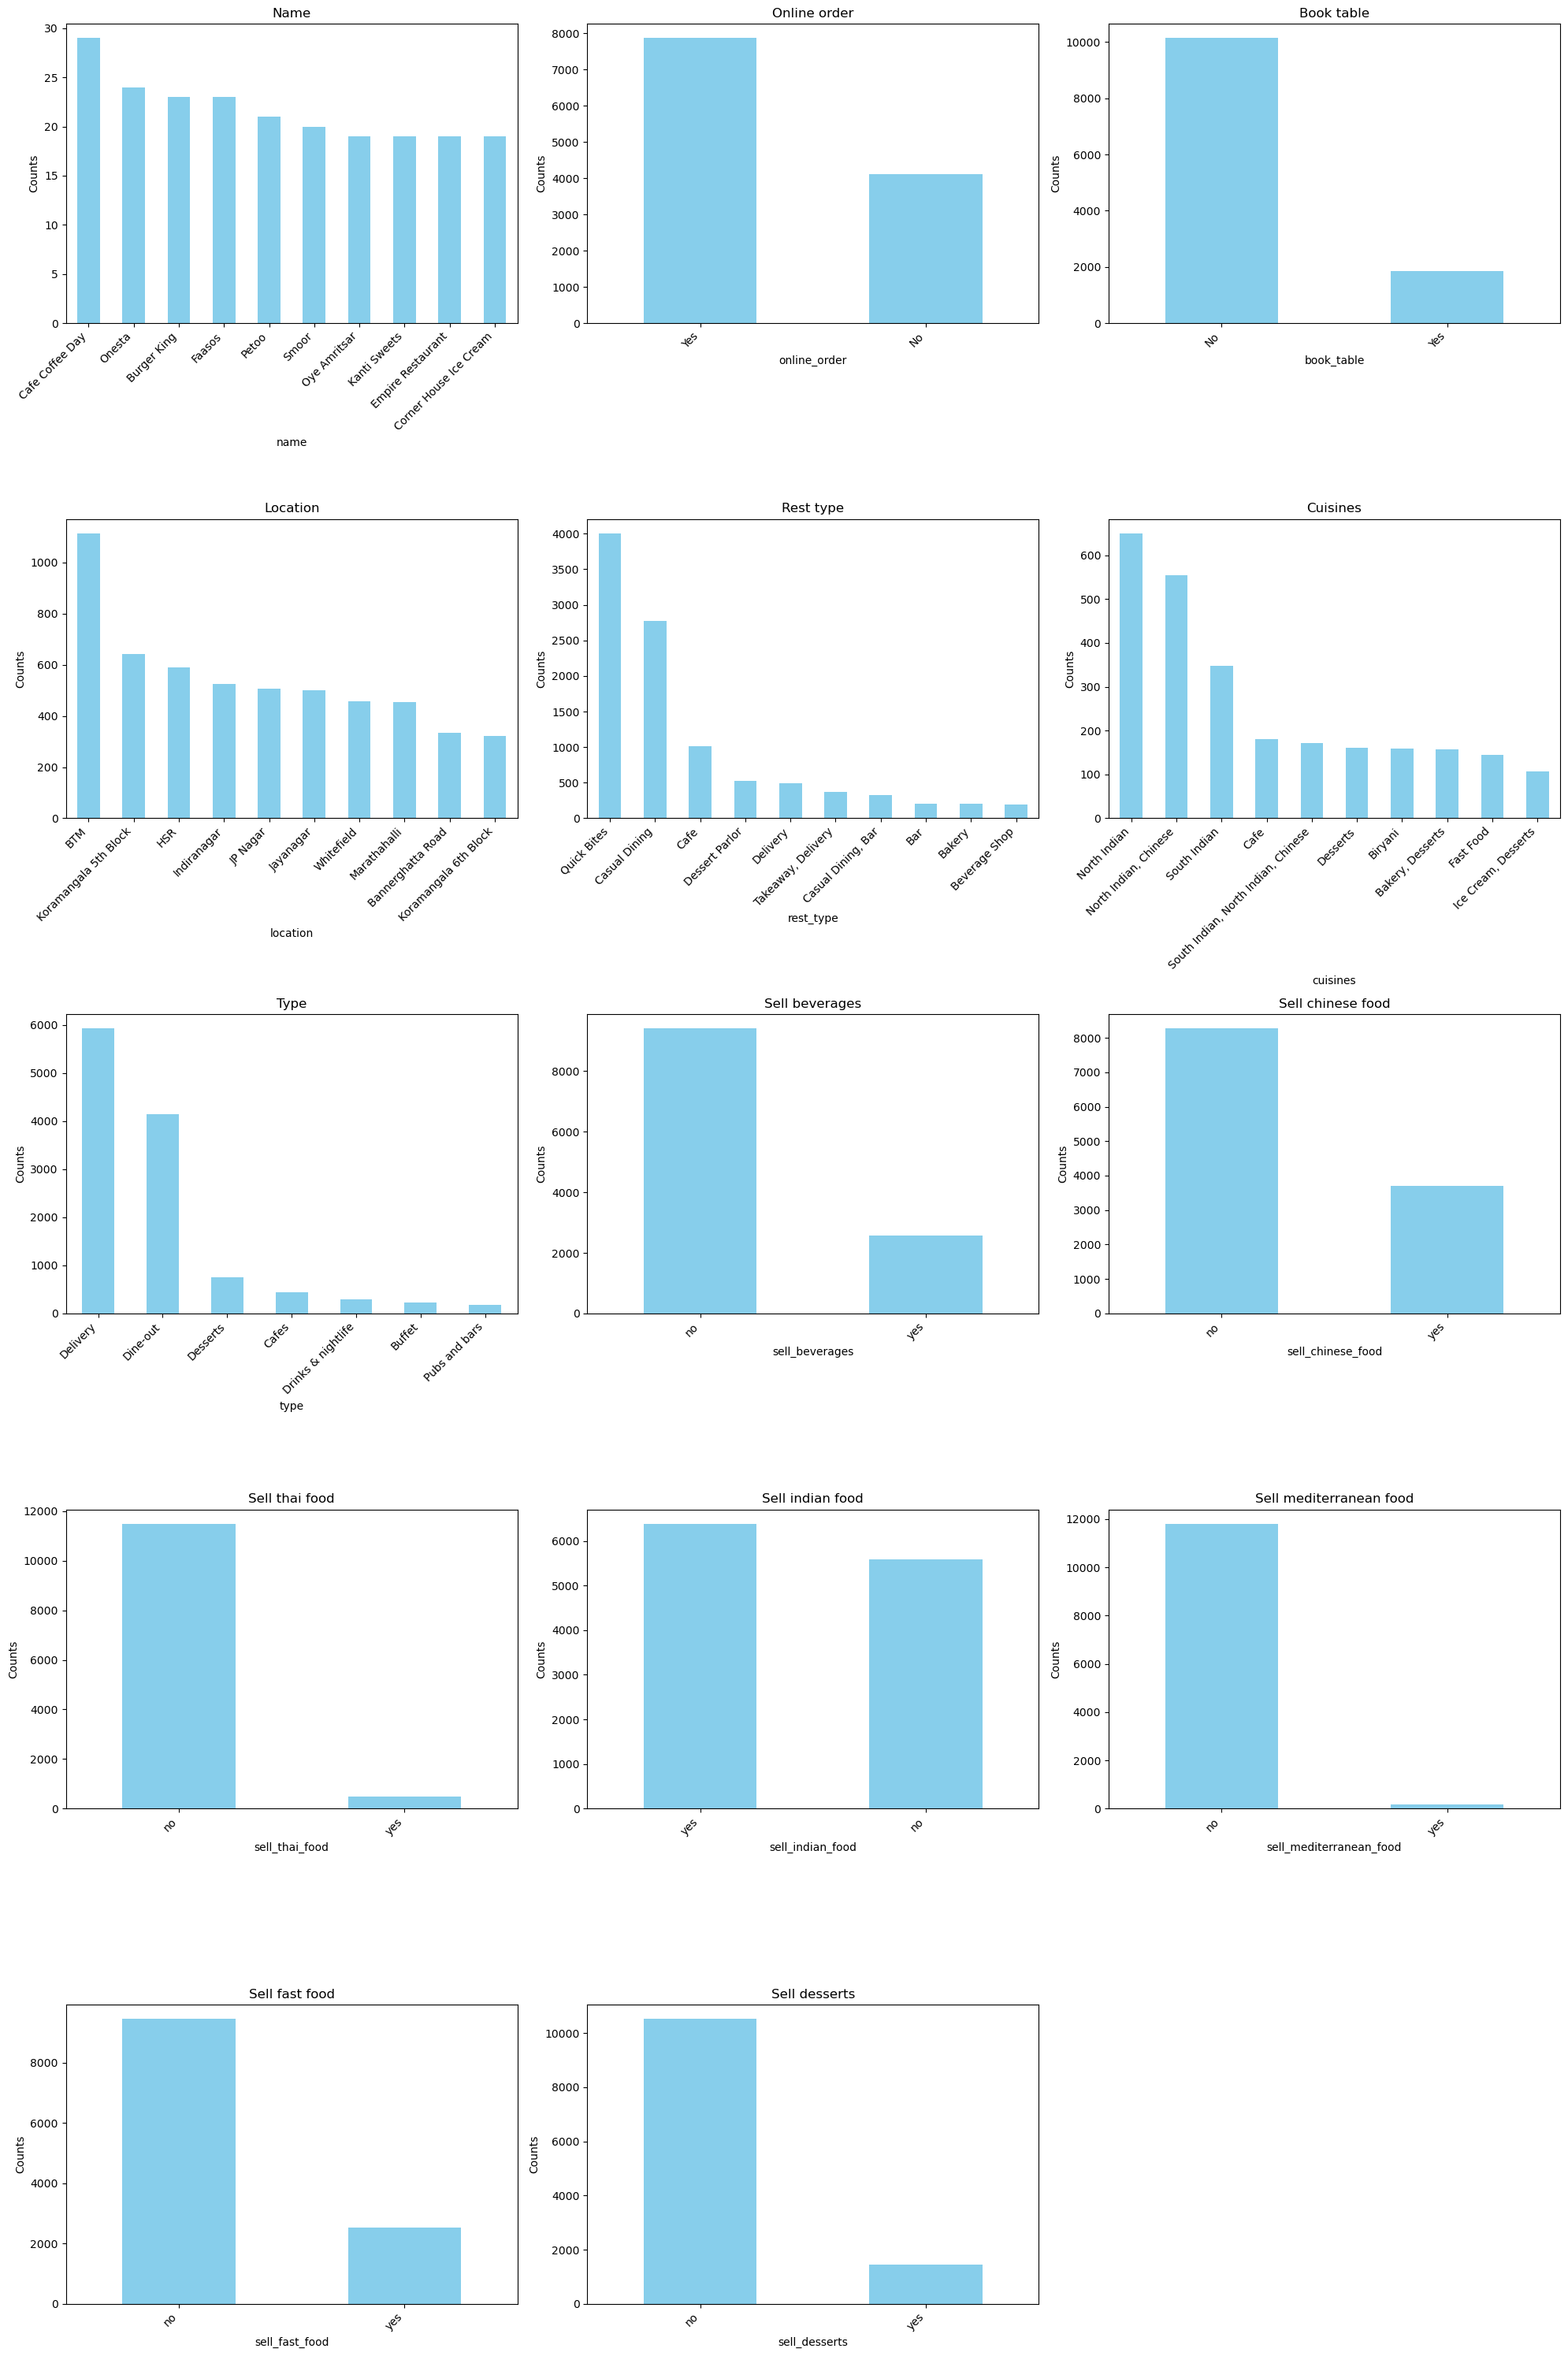

In [ ]:
plt.figure(figsize=(20, 30))

for i, column in enumerate(categorical_columns, 1):
    plt.subplot(5, 3, i)
    value_counts = df[column].value_counts().head(10)
    value_counts.plot(kind='bar', color='skyblue')
    plt.title(column.replace('_', ' ').capitalize())
    plt.ylabel('Counts')
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [29]:
for i in categorical_columns:
    print(df[i].value_counts())
    print("")

name
Cafe Coffee Day            29
Onesta                     24
Burger King                23
Faasos                     23
Petoo                      21
                           ..
The Lovin' Oven Cakery      1
Zengi Pub & Restaurant      1
Janahaar                    1
Brother?s Bar & Kitchen     1
Sri Vasavi Restaurant       1
Name: count, Length: 4720, dtype: int64

online_order
Yes    7869
No     4107
Name: count, dtype: int64

book_table
No     10137
Yes     1839
Name: count, dtype: int64

location
BTM                      1114
Koramangala 5th Block     642
HSR                       590
Indiranagar               524
JP Nagar                  508
                         ... 
North Bangalore             2
Kengeri                     2
Yelahanka                   1
West Bangalore              1
Rajarajeshwari Nagar        1
Name: count, Length: 90, dtype: int64

rest_type
Quick Bites                  4005
Casual Dining                2771
Cafe                         1008
Desser

# Insight

- Name: Popular restaurant chains like "Cafe Coffee Day,", "Onesta," and "Burger King" dominate the dataset, indicating a preference for well-known brands.
- Online Order: A significant majority of restaurants offer online ordering, showing its importance in the food industry.
- Book Table: Most restaurants do not provide table booking services, possibly reflecting a preference for casual dining.
- Location: Areas like BTM, Koramangala 5th Block, and HSR are food hubs, with the highest number of restaurants in the dataset.
- Rest Type: Quick Bites and Casual Dining are the most prevalent restaurant types, aligning with consumer preferences for convenience and relaxed dining.
- Cuisines: North Indian and Chinese cuisines are the most commonly served, reflecting their popularity.
- Type: Delivery and Dine-out dominate, suggesting a balance between home dining and eating out.
- A majority of restaurants serve Indian food, as expected in an Indian market.
- While the other types of cuisines dont appears often.


# Data Preprocessing

## Multivariate Column Handling

## Encoding

In [30]:
df['online_order'] = df['online_order'].map({'No': 0, 'Yes': 1})
df['book_table'] = df['book_table'].map({'No': 0, 'Yes': 1})
df['sell_beverages'] = df['sell_beverages'].map({'no': 0, 'yes': 1})
df['sell_chinese_food'] = df['sell_chinese_food'].map({'no': 0, 'yes': 1})
df['sell_thai_food'] = df['sell_thai_food'].map({'no': 0, 'yes': 1})
df['sell_indian_food'] = df['sell_indian_food'].map({'no': 0, 'yes': 1})
df['sell_mediterranean_food'] = df['sell_mediterranean_food'].map({'no': 0, 'yes': 1})
df['sell_fast_food'] = df['sell_fast_food'].map({'no': 0, 'yes': 1})
df['sell_desserts'] = df['sell_desserts'].map({'no': 0, 'yes': 1})

I ndid some binary encoding on some of the variables and i dont encode the rest because its contain valuable text information

## Scaling

In [ ]:
scaler = RobustScaler()
df[['cost', 'votes', 'rate']] = scaler.fit_transform(df[['cost', 'votes', 'rate']])

I did a robust scaling because some of the numerical data was skewed heavily

## Check if a restaurant have the same name, diffrent location

In [ ]:
duplicates = df.groupby(['name', 'location', 'rest_type']).size().reset_index(name='count')

multiple_entries = duplicates[duplicates['count'] > 1]
multiple_entries

,name,location,rest_type,count
1,#L-81 Cafe,HSR,Quick Bites,2
2,1000 B.C,Koramangala 5th Block,Quick Bites,2
5,1131 Bar + Kitchen,Indiranagar,"Bar, Casual Dining",2
6,12th Main - Grand Mercure,Koramangala 3rd Block,Fine Dining,3
8,1522 - The Pub,Koramangala 4th Block,Pub,6
...,...,...,...,...
6175,eat.fit,Church Street,Quick Bites,3
6177,eat.fit,Koramangala 5th Block,Delivery,2
6179,i-Bar - The Park Bangalore,MG Road,Lounge,5
6181,iSpice Resto Cafe,Indiranagar,Cafe,2


Yes, most of the restaurant hvae multi braches and we need to preprocess the data to handle it.

In [33]:
def preprocess_dataframe(df):
    return (
        df.groupby('name')
        .agg({
            'cuisines': lambda x: ', '.join(set(', '.join(x).split(', '))),
            'location': lambda x: ', '.join(set(', '.join(x).split(', '))),
            'rest_type': lambda x: ', '.join(set(', '.join(x).split(', '))),
            'type': lambda x: ', '.join(set(', '.join(x).split(', '))),
            'rate': 'mean',
            'votes': 'mean',
            'cost': 'mean',
        })
        .reset_index()
    )

Combine values without having duplicated results. cuisines, location, ret_type & type i combine the unique value only to ensures consistency across features and avoid bias towards multi-branch restaurants.

In [34]:
df = preprocess_dataframe(df)

In [35]:
df.head()

,name,cuisines,location,rest_type,type,rate,votes,cost
0,#FeelTheROLL,Fast Food,Bellandur,Quick Bites,Delivery,-0.500000,-0.253846,-0.750
1,#L-81 Cafe,"Fast Food, Beverages",HSR,Quick Bites,"Dine-out, Delivery",0.333333,-0.096154,-0.250
2,1000 B.C,"Sandwich, Arabian, Burger, Rolls",Koramangala 5th Block,Quick Bites,Delivery,-0.833333,-0.092308,-0.500
3,100°C,"North Indian, Biryani",BTM,Casual Dining,Dine-out,0.000000,-0.123077,-0.125
4,11 to 11 Express Biriyanis,"Kebab, Biryani",Electronic City,Quick Bites,Dine-out,-0.333333,-0.196154,-0.500


# Model

## Soup Technique

In [ ]:
def create_soup(df, weights):
    soup = []
    for idx, row in df.iterrows():
        unique_location = set(row['location'].split(" "))  
        unique_rest_type = set(row['rest_type'].split(" "))  
        unique_cuisines = set(row['cuisines'].split(" "))  
        unique_type = set(row['type'].split(" "))  
        
        text = (
            " ".join([loc for loc in unique_location] * weights['location']) + " " +
            " ".join([rest for rest in unique_rest_type] * weights['rest_type']) + " " +
            " ".join([cuisine for cuisine in unique_cuisines] * weights['cuisines']) + " " +
            " ".join([t for t in unique_type] * weights['type'])
        )
        
        if 'rate' in df.columns:
            text += " " + " ".join(["rate"] * int(row['rate'] * weights['rate']))
        if 'votes' in df.columns:
            text += " " + " ".join(["vote"] * int(row['votes'] * weights['votes']))
        
        soup.append(text)
    
    return soup

In this soup technique i only use location, rest_type, cuisines, and type because they represent categorical & textual information more than others. I also include rate & vote as they reflect the popularity of a restaurant. 

In [37]:
weights = {
    'location': 6,
    'rest_type': 5,
    'cuisines': 7,
    'type': 4,
    'rate': 6,
    'votes': 5,
    'cost': 4
}

df['soup'] = create_soup(df, weights)

The weighting method (subjective) I applied reflects a balanced approach to prioritizing features based on their importance in determining restaurant similarity. The weights are designed to emphasize the aspects of a restaurant that most significantly influence customer preferences while maintaining a holistic view of the factors contributing to a restaurant's identity.

- cuisines (7): This feature has the highest weight because the type of food a restaurant offers is typically the most decisive factor for customers. It defines the core identity of the restaurant and directly aligns with the primary reason customers select a dining establishment.

- location (6): Location is a critical aspect of convenience and accessibility. A restaurant's proximity or placement within a specific area can greatly influence customer decisions, making it a high-priority feature.

- rate (6): Ratings provide a quick and reliable measure of customer satisfaction, which is crucial in building trust. A restaurant with a high rating often stands out as a preferred choice for many customers.

- votes (5): The number of votes reflects the popularity and credibility of the rating. While less critical than the rating itself, a high number of votes ensures reliability, making this an important feature.

- rest_type (5): This feature describes the nature of the restaurant, such as casual dining, fine dining, or cafes. It plays a significant role in aligning with customer preferences for different occasions, like casual outings or formal dinners.

- type (4): This feature indicates the service options available, such as dine-in, delivery, or takeaway. While important, its influence depends on the customer's immediate needs, making it slightly less weighted.

- cost (4): Cost is a key factor for budget-conscious customers, but its importance varies widely across different customer segments. It has been assigned a moderate weight to reflect its role without overshadowing other features.


In [38]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['soup'])

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [ ]:
def get_recommendations_with_details(name, cosine_sim=cosine_sim, df=df):
    if name not in df['name'].values:
        return f"Restaurant '{name}' not found in the dataset."
    
    idx = df[df['name'] == name].index[0]
    
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    
    restaurant_indices = [i[0] for i in sim_scores]
    
    recommendations = df.iloc[restaurant_indices].copy()
    recommendations['similarity_score'] = [sim_scores[i][1] for i in range(len(sim_scores))]
    
    result = recommendations[['name','cuisines', 'location', 'rest_type', 'type', 'rate', 'votes','cost', 'similarity_score']]
    result = result.sort_values(by='similarity_score', ascending=False)
    return result

# Evaluation

First, lets try with the most common restaurant chain like cafes

In [40]:
name = "Black Cup Cafe"
df[df['name']== name]

,name,cuisines,location,rest_type,type,rate,votes,cost,soup
580,Black Cup Cafe,"Fast Food, Cafe, Beverages",BTM,Cafe,"Dine-out, Delivery",-0.033333,-0.18,-0.25,BTM BTM BTM BTM BTM BTM Cafe Cafe Cafe Cafe Ca...


In [41]:
recommendations_df = get_recommendations_with_details(name)
recommendations_df

,name,cuisines,location,rest_type,type,rate,votes,cost,similarity_score
2292,Kullad Cafe,"North Indian, Cafe, Beverages, Fast Food",BTM,Cafe,"Cafes, Dine-out, Delivery",0.333333,0.989423,-0.75,0.924363
730,Cafe Hush,"Fast Food, Cafe",BTM,Cafe,"Cafes, Dine-out, Delivery",-0.166667,-0.196154,0.00,0.876125
752,Cafe Orio,"Fast Food, Cafe",BTM,Cafe,"Cafes, Dine-out",0.500000,0.284615,-0.25,0.867707
701,Cafe 221B,"Cafe, Beverages",BTM,Cafe,"Cafes, Dine-out, Delivery",0.000000,-0.092308,-0.50,0.859817
1626,Granos De Cafe,"Cafe, Beverages",BTM,Cafe,Cafes,0.000000,-0.161538,0.00,0.847699
1375,FIFA Cafe,"Fast Food, Cafe, Beverages",Marathahalli,Cafe,Cafes,-0.833333,-0.265385,-0.50,0.830414
3120,People Tree Cafe,"Fast Food, Cafe, Beverages",Jayanagar,Cafe,Cafes,0.000000,0.365385,-0.25,0.820968
384,Bakers Town,"Fast Food, Cafe, Continental",BTM,Cafe,"Cafes, Dine-out, Delivery",-0.166667,-0.121538,0.25,0.814477
3551,Sea Green Cafe,"Fast Food, Cafe, Beverages",Banashankari,Cafe,"Cafes, Dine-out",-0.666667,-0.265385,0.00,0.810547
1153,De Oxford Cafe,"Fast Food, Cafe, Beverages",JP Nagar,Cafe,"Cafes, Dine-out",0.000000,-0.150000,0.00,0.796128


Second, lets try with the least common restaurant chain like pubs and bars

In [42]:
name = 'Hard Rock Cafe'
df[df['name']== name]

,name,cuisines,location,rest_type,type,rate,votes,cost,soup
1707,Hard Rock Cafe,"American, BBQ",St. Marks Road,"Casual Dining, Bar","Pubs and bars, Drinks & nightlife",1.333333,20.007692,5.0,St. Road Marks St. Road Marks St. Road Marks S...


In [43]:
# Even though the name was hard rock cafe it was categorize as pubs and bars which may a great test for our reccomendation system
recommendations_df = get_recommendations_with_details(name)
recommendations_df

,name,cuisines,location,rest_type,type,rate,votes,cost,similarity_score
279,Arbor Brewing Company,"Continental, American",Brigade Road,"Pub, Microbrewery","Dine-out, Drinks & nightlife",1.333333,32.040385,3.75,0.932223
520,Big Pitcher,"North Indian, Continental, American, Mediterra...",Old Airport Road,"Pub, Microbrewery","Pubs and bars, Buffet, Drinks & nightlife, Din...",1.600000,34.853846,3.25,0.928299
686,Byg Brewski Brewing Company,"South Indian, North Indian, Finger Food, Conti...",Sarjapur Road,Microbrewery,"Dine-out, Drinks & nightlife",2.000000,63.208974,2.75,0.926675
4129,The Black Pearl,"North Indian, European, Mediterranean",Koramangala 5th Block,"Casual Dining, Bar","Dine-out, Pubs and bars, Buffet",1.666667,40.186154,2.25,0.925456
1755,Hoot,"North Indian, Continental, Italian",Sarjapur Road,"Pub, Microbrewery","Pubs and bars, Delivery, Drinks & nightlife",0.833333,27.625824,2.25,0.921625
3969,TBC Sky Lounge,"North Indian, Continental, Italian, Asian",HSR,"Casual Dining, Bar",Drinks & nightlife,1.666667,25.661538,1.25,0.921350
3189,Prost Brew Pub,"North Indian, Continental, American, Salad",Koramangala 4th Block,"Pub, Microbrewery","Dine-out, Drinks & nightlife",1.333333,29.946923,3.25,0.919667
4625,Windmills Craftworks,"North Indian, American, Salad",Whitefield,"Pub, Microbrewery","Dine-out, Drinks & nightlife",1.500000,22.496154,5.00,0.917004
4524,Vapour Pub & Brewery,"North Indian, Continental, Chinese",Indiranagar,"Pub, Microbrewery",Pubs and bars,0.833333,26.284615,2.25,0.915899
4220,The Hole in the Wall Cafe,"Cafe, American, Burger",Koramangala 4th Block,Cafe,Dine-out,1.500000,27.125000,0.25,0.914462


Last, lets pick random restaurant

In [44]:
name = "Cinnamon's Kitchen"
df[df['name']== name]

,name,cuisines,location,rest_type,type,rate,votes,cost,soup
997,Cinnamon's Kitchen,"North Indian, South Indian, Fast Food",Old Airport Road,Quick Bites,Delivery,0.0,-0.184615,-0.5,Airport Old Road Airport Old Road Airport Old ...


In [45]:
# Random Restaurant 
recommendations_df = get_recommendations_with_details(name)
recommendations_df

,name,cuisines,location,rest_type,type,rate,votes,cost,similarity_score
911,Chef Fast Food,"Fast Food, South Indian, North Indian",Old Airport Road,Quick Bites,Delivery,-0.916667,-0.178846,-0.500,0.985091
507,Bhookha Sher,"North Indian, Fast Food",Old Airport Road,Quick Bites,"Dine-out, Delivery",-0.444444,-0.189744,-0.375,0.947089
891,Chatora Singh,"North Indian, Fast Food",Old Airport Road,Quick Bites,Dine-out,0.333333,-0.111538,-0.750,0.941999
1504,Fresh Bowl,"North Indian, Chinese, Fast Food",Old Airport Road,Quick Bites,Delivery,-0.666667,-0.265385,-0.250,0.925139
4243,The Kitchen Chef,"Fast Food, Chinese, North Indian",Old Airport Road,Delivery,Delivery,-1.333333,0.080769,0.000,0.894220
2461,Mac Fast Food,"Fast Food, Chinese",Old Airport Road,Quick Bites,"Dine-out, Delivery",-1.500000,-0.088462,-0.250,0.878799
2795,Nandini Andhra Style Mess,"North Indian, Chinese, South Indian",Old Airport Road,Quick Bites,Delivery,-0.500000,-0.173077,-0.375,0.862967
4304,The Punjabi Bites,North Indian,Old Airport Road,Quick Bites,Dine-out,0.333333,0.034615,-0.875,0.839781
4335,The Spice Box,"North Indian, South Indian",Old Airport Road,Casual Dining,Dine-out,-0.166667,-0.165385,0.750,0.822066
1194,Desi Bytes,"North Indian, Chinese",Old Airport Road,Quick Bites,"Dine-out, Delivery",-1.000000,0.092308,-0.125,0.815700


# Conclussion

The restaurant recommendation system demonstrates notable strengths in capturing and reflecting similarities across diverse restaurant types. By leveraging weighted features such as location, cuisines, type, and other factors, it aligns well with the specific characteristics that diners often prioritize. Here's a critical evaluation of the system based on  results:

- In my recommendation system, I focused more on location after the cuisine, ensuring that the recommendations are more relevant to the user's immediate area. As a result, the system doesn't offer broad diversity in terms of locations. A restaurant-based recommendation system is particularly effective when it is focused on a specific, limited location. For example, if people are familiar with a cafe and decide to seek recommendations based on it, they likely want to find similar restaurants nearby.
- In the case of Black Cup Cafe, the recommendations successfully prioritized similar delivery-focused restaurants with a comparable menu. This indicates that the system effectively incorporates features such as type and cuisines to identify relevant matches.
- For Hard Rock Cafe, which belongs to the "pubs and bars" category(lowest data category), the recommendations featured other establishments in the same category and with similar ambiance and services, demonstrating the effectiveness of the weighting for location & rest_type.
- For Cinnamon's Kitchen a random restaurant i choose with indian type of cuisine, it still succesfully reccomend the similar types of cafes with a good similarity_score. This indicates the reccomendation system was overall great with any cases.


The restaurant recommendation system developed in this project offers a robust, data-driven approach to discovering dining options tailored to diverse preferences. By incorporating weighted features such as location, type, cuisines, and ratings, the system demonstrates high contextual accuracy and relevance across different restaurant categories. Its ability to provide similarity scores adds transparency, aiding users in making informed decisions. While the system is effective in its current form, future enhancements could include broader diversity in recommendations, deeper analysis for popular chains, and user-specific customization to improve personalization. Overall, this system is a strong foundation for further exploration and refinement in the domain of restaurant recommendations, showcasing the power of machine learning in addressing real-world decision-making challenges.
